# Road Network Analysis and Classification using Python and Geospatial Libraries

## Project Overview

This project explores the use of Python and geospatial libraries to analyze road networks, classify different road types, and perform route analysis. The key objectives of this project include:

1. **Download and process road network data** from OpenStreetMap (OSM) using the `osmnx` library.
2. **Classify different road types** based on geometric features like curvature and length. The road types include **Straight Roads, Curved Roads, Zigzag Roads, Circular Roads (Roundabouts), Highways, Residential Roads, Arterial Roads, Boulevards**, among others.
3. **Leverage machine learning** techniques to predict and classify roads based on features such as curvature, slope, and elevation changes.
4. **Visualize the results** using geospatial mapping libraries like `folium`, providing an intuitive way to view and analyze road networks and classifications.

## Key Steps Involved

- **Data Collection:** We used `osmnx` to download road network data for Mumbai, India, from OpenStreetMap.
- **Geospatial Data Processing:** The road network was converted into GeoDataFrames using `osmnx`'s `graph_to_gdfs` function, which provided access to nodes and edges of the network.
- **Curvature Analysis:** We calculated the curvature of each road segment to classify roads as **straight**, **curved**, **zigzag**, or **circular (roundabout)** by analyzing the rate of change in direction along each road segment.
- **Road Type Classification:** Based on curvature and other features like road length, we classified roads into categories such as highways, residential roads, ramps, and service roads.
- **Machine Learning:** We used classification algorithms (e.g., Random Forest) to predict road types based on extracted features.
- **Visualization:** We visualized the road network and its classification using the `folium` library, creating an interactive map to explore the results.


In [1]:
#! pip install osmnx geopandas shapely scikit-learn matplotlib contextily pandas numpy


In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import numpy as np
import pandas as pd
from shapely.geometry import LineString
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx


# Data Collection
We can use OpenStreetMap (OSM) data to retrieve road network data for a particular location. The osmnx library allows you to download road networks and convert them into usable graph structures.

In [3]:
# Download the road network for a specific city (example: Mumbai, India)
#place_name = "Mumbai, India"
#graph = ox.graph_from_place(place_name, network_type='all')


# Save The Graph To A GraphML File

In [4]:
#ox.save_graphml(graph, 'mumbai_road_network.graphml')


# Load The Road Network From The GraphML File

In [5]:
graph = ox.load_graphml("mumbai_road_network.graphml")

# Print basic graph information
print(ox.basic_stats(graph))


{'n': 37500, 'm': 88419, 'k_avg': 4.71568, 'edge_length_total': 7790275.227393303, 'edge_length_avg': 88.10634849289522, 'streets_per_node_avg': 2.67544, 'streets_per_node_counts': {0: 0, 1: 8677, 2: 64, 3: 23606, 4: 5062, 5: 88, 6: 3}, 'streets_per_node_proportions': {0: 0.0, 1: 0.23138666666666666, 2: 0.0017066666666666667, 3: 0.6294933333333333, 4: 0.13498666666666667, 5: 0.0023466666666666666, 6: 8e-05}, 'intersection_count': 28823, 'street_length_total': 4452091.720963419, 'street_segment_count': 50150, 'street_length_avg': 88.77550789558164, 'circuity_avg': 1.1124719582402607, 'self_loop_proportion': 0.006699900299102692}


# Convert Graph to Geometries
Convert the graph data into road geometries that can be analyzed for curvature and other features.

In [6]:
# Convert the graph into GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph) 


# Curvature and Road Geometry Analysis
To identify road types like `straight`, `curved`, or `zigzag`, we need to analyze the curvature of the road segments. We can calculate curvature as the rate of change in direction between points along each road.

In [7]:
def calculate_curvature(line):
    coords = list(line.coords)
    angles = []
    for i in range(1, len(coords) - 1):
        angle = calculate_angle(coords[i-1], coords[i], coords[i+1])
        angles.append(angle)
    return angles

def calculate_angle(p1, p2, p3):

    # Calculate the angle between three points using vector math
    vector1 = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    vector2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    cosine_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return np.arccos(cosine_angle)


# Apply curvature calculation to each road segment
edges['curvature'] = edges['geometry'].apply(lambda x: calculate_curvature(x))


C:\Users\sanjay\AppData\Local\Temp\ipykernel_7084\1148388126.py:15: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cosine_angle)


# Classify Road Types
Based on curvature values, classify roads into the following categories:

### Straight Roads: Curvature close to zero.
### Curved Roads: Constant, low-level curvature.
### Zigzag Roads: Alternating high and low curvature.
### Circular Roads (Roundabouts): Roads with constant curvature.

In [8]:
def classify_road_type(curvature):
    if all(abs(c) < 0.1 for c in curvature):  # Straight roads (low curvature)
        return 'Straight'
    elif len(set(curvature)) == 1:  # Circular roads (constant curvature)
        return 'Circular'
    elif any(c > 0.5 for c in curvature):  # Zigzag roads (high curvature)
        return 'Zigzag'
    else:
        return 'Curved'

# Apply classification
edges['road_type'] = edges['curvature'].apply(classify_road_type)


## Feature Extraction
Extract additional features that can help classify the road types, such as road length, slope, and more. For example, straight roads might have longer lengths compared to curved roads.

In [9]:
# Calculate road length
edges['length'] = edges['geometry'].length

# Identify additional features such as whether the road is a highway, residential, or arterial road
# For simplicity, assume manual classification
edges['is_highway'] = edges['highway'].apply(lambda x: 1 if x == 'motorway' else 0)
edges['is_residential'] = edges['highway'].apply(lambda x: 1 if x == 'residential' else 0)


C:\Users\sanjay\AppData\Local\Temp\ipykernel_7084\2545327010.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['length'] = edges['geometry'].length


# Prepare Data For Machine Learning
# Selected Features For Classification Model

In [10]:
features = ['length', 'is_highway', 'is_residential']
X = edges[features]  # Features (input data)
y = edges['road_type']  # Target variable (road types)

# Standardize The Features To Have Zero Mean And Unit Variance

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split To Evaluate Model Performance

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Plot The Distribution Of Each Feature Before And After Scaling

A histogram or density plot is useful to see the distribution of the features before and after scaling.

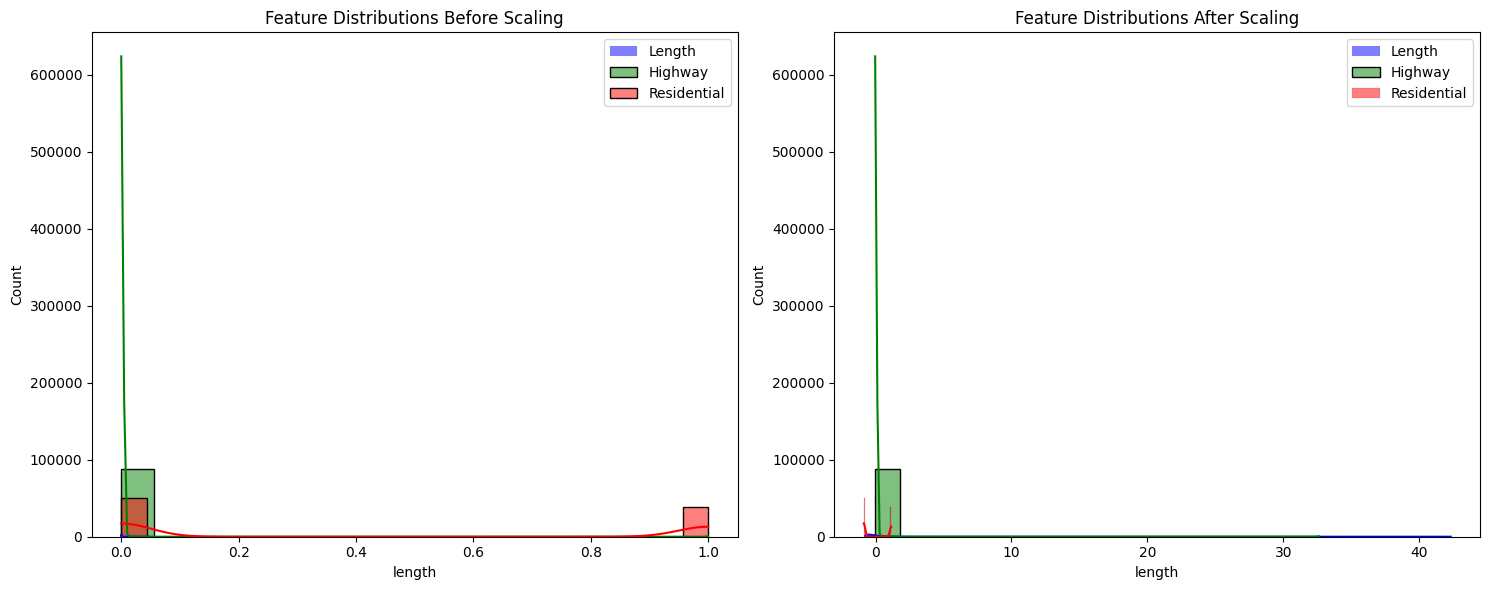

In [13]:
#features before scaling
features_before = edges[['length', 'is_highway', 'is_residential']]

features_after = pd.DataFrame(X_scaled, columns=features_before.columns)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before Scaling
sns.histplot(features_before['length'], kde=True, ax=axes[0], color='blue', label='Length')
sns.histplot(features_before['is_highway'], kde=True, ax=axes[0], color='green', label='Highway')
sns.histplot(features_before['is_residential'], kde=True, ax=axes[0], color='red', label='Residential')
axes[0].set_title('Feature Distributions Before Scaling')
axes[0].legend()

# After Scaling
sns.histplot(features_after['length'], kde=True, ax=axes[1], color='blue', label='Length')
sns.histplot(features_after['is_highway'], kde=True, ax=axes[1], color='green', label='Highway')
sns.histplot(features_after['is_residential'], kde=True, ax=axes[1], color='red', label='Residential')
axes[1].set_title('Feature Distributions After Scaling')
axes[1].legend()

plt.tight_layout()
plt.show()


# Train a Random Forest Model And Perform Cross-Validation To Check Model Performance

In [14]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {np.mean(cv_scores)}")

Cross-validation scores: [0.76847888 0.76557072 0.76718636 0.76789465 0.77338827]
Average cross-validation score: 0.7685037770889622


# Fit The Model To The Training Data

In [15]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Plotting The Cross-Validation Results

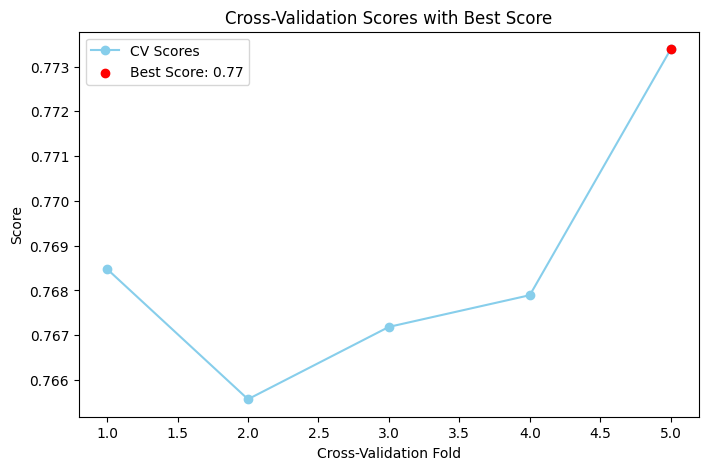

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='skyblue', linestyle='-', label='CV Scores')

# Highlight the best score
best_score = np.max(cv_scores)
best_fold = np.argmax(cv_scores) + 1
ax.scatter(best_fold, best_score, color='red', label=f'Best Score: {best_score:.2f}', zorder=5)

# Add labels and title
ax.set_xlabel('Cross-Validation Fold')
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Scores with Best Score')
ax.legend()

# Show the plot
plt.show()

# Count The Occurrences Of Each Road Type

In [17]:
road_type_counts = edges['road_type'].value_counts()
print(road_type_counts)

road_type
Straight    57333
Zigzag      13306
Curved      10824
Circular     6956
Name: count, dtype: int64


# Plot map Road Type Classification

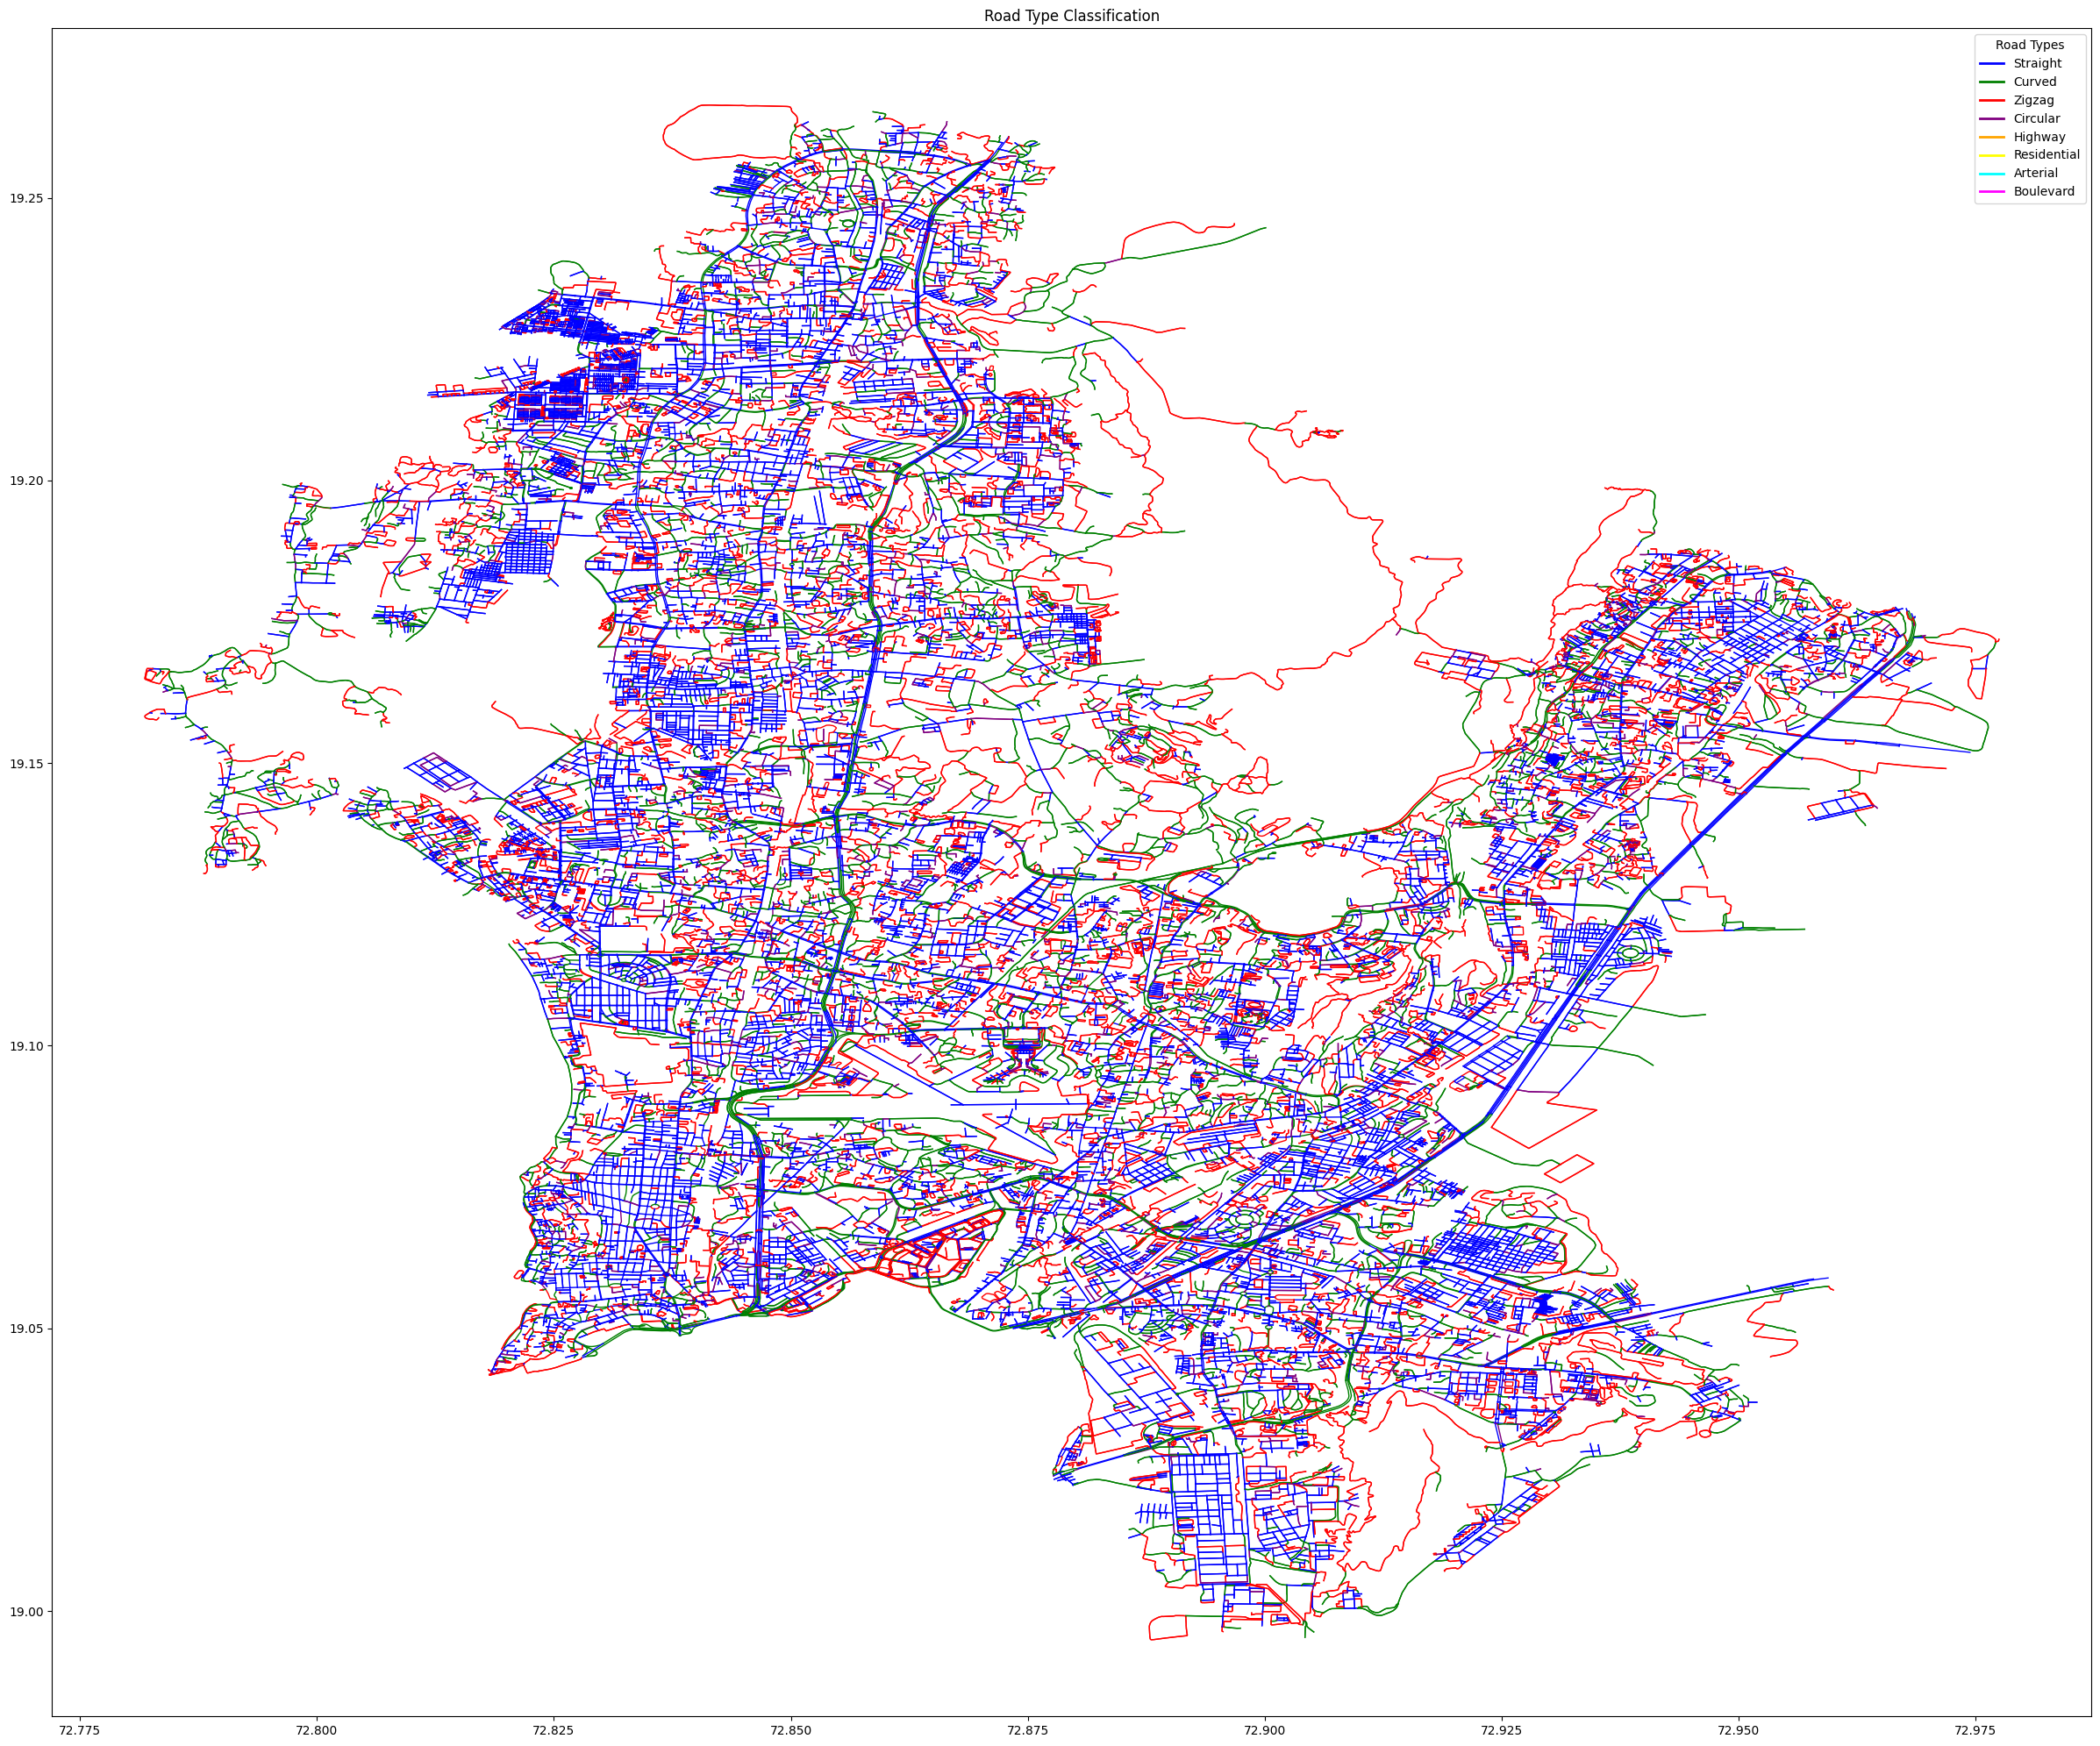

In [18]:
# Set up a color mapping for different road types
road_type_colors = {
    'Straight': 'blue',
    'Curved': 'green',
    'Zigzag': 'red',
    'Circular': 'purple',
    'Highway': 'orange', 
    'Residential': 'yellow',
    'Arterial': 'cyan',
    'Boulevard': 'magenta'
}

fig, ax = plt.subplots(figsize=(30, 25))

# Iterate over the roads and plot them
for _, row in edges.iterrows():
    color = road_type_colors.get(row['road_type'], 'gray')
    x, y = row['geometry'].xy
    ax.plot(x, y, color=color, linewidth=1)

ax.set_title('Road Type Classification')

# Create a legend
handles = [plt.Line2D([0], [0], color=color, lw=2) for color in road_type_colors.values()]
labels = road_type_colors.keys()
ax.legend(handles, labels, title="Road Types")

plt.show()


# Road Type Distribution

Visualize the distribution of different road types (before and after classification) with a pie chart or bar plot

# Plot Road Type Distribution

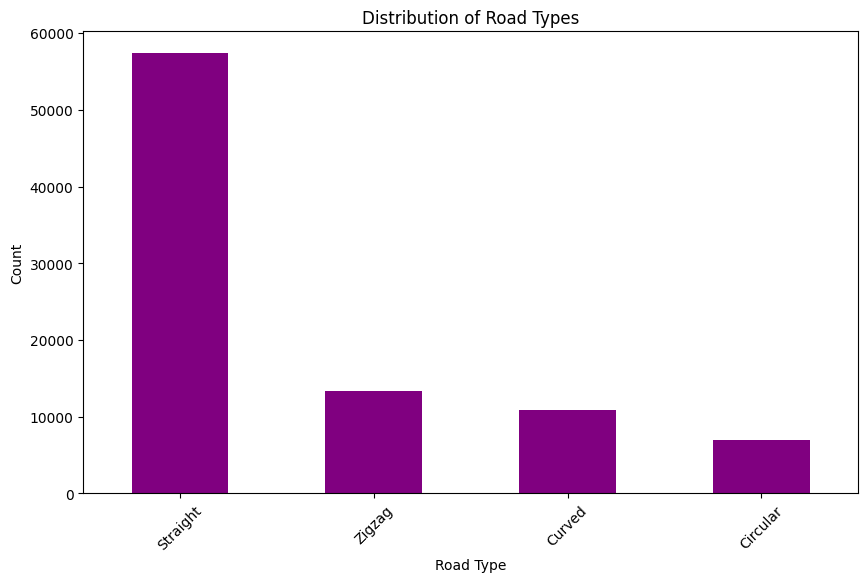

In [19]:
road_type_counts = edges['road_type'].value_counts()

road_type_counts.plot(kind='bar', figsize=(10, 6), color='purple')
plt.title('Distribution of Road Types')
plt.xlabel('Road Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



# Pie Chart For Road Types

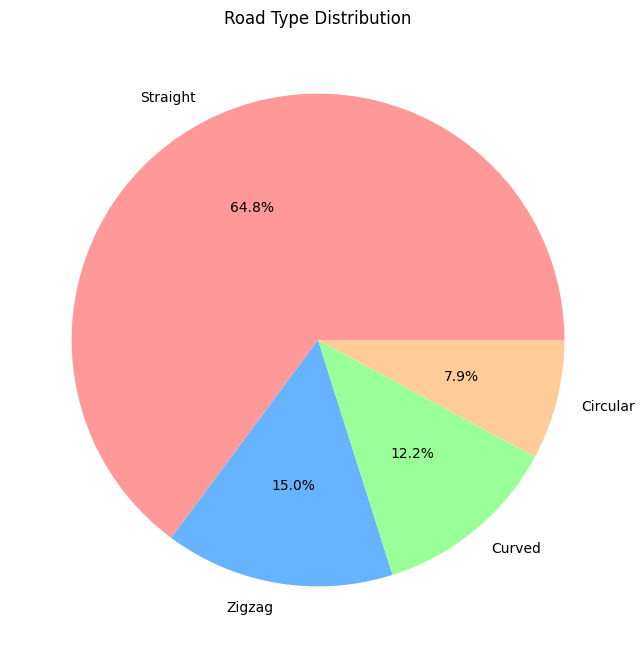

In [20]:
road_type_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Road Type Distribution')
plt.ylabel('')  # Remove the label on the left
plt.show()

# Plot Road Network

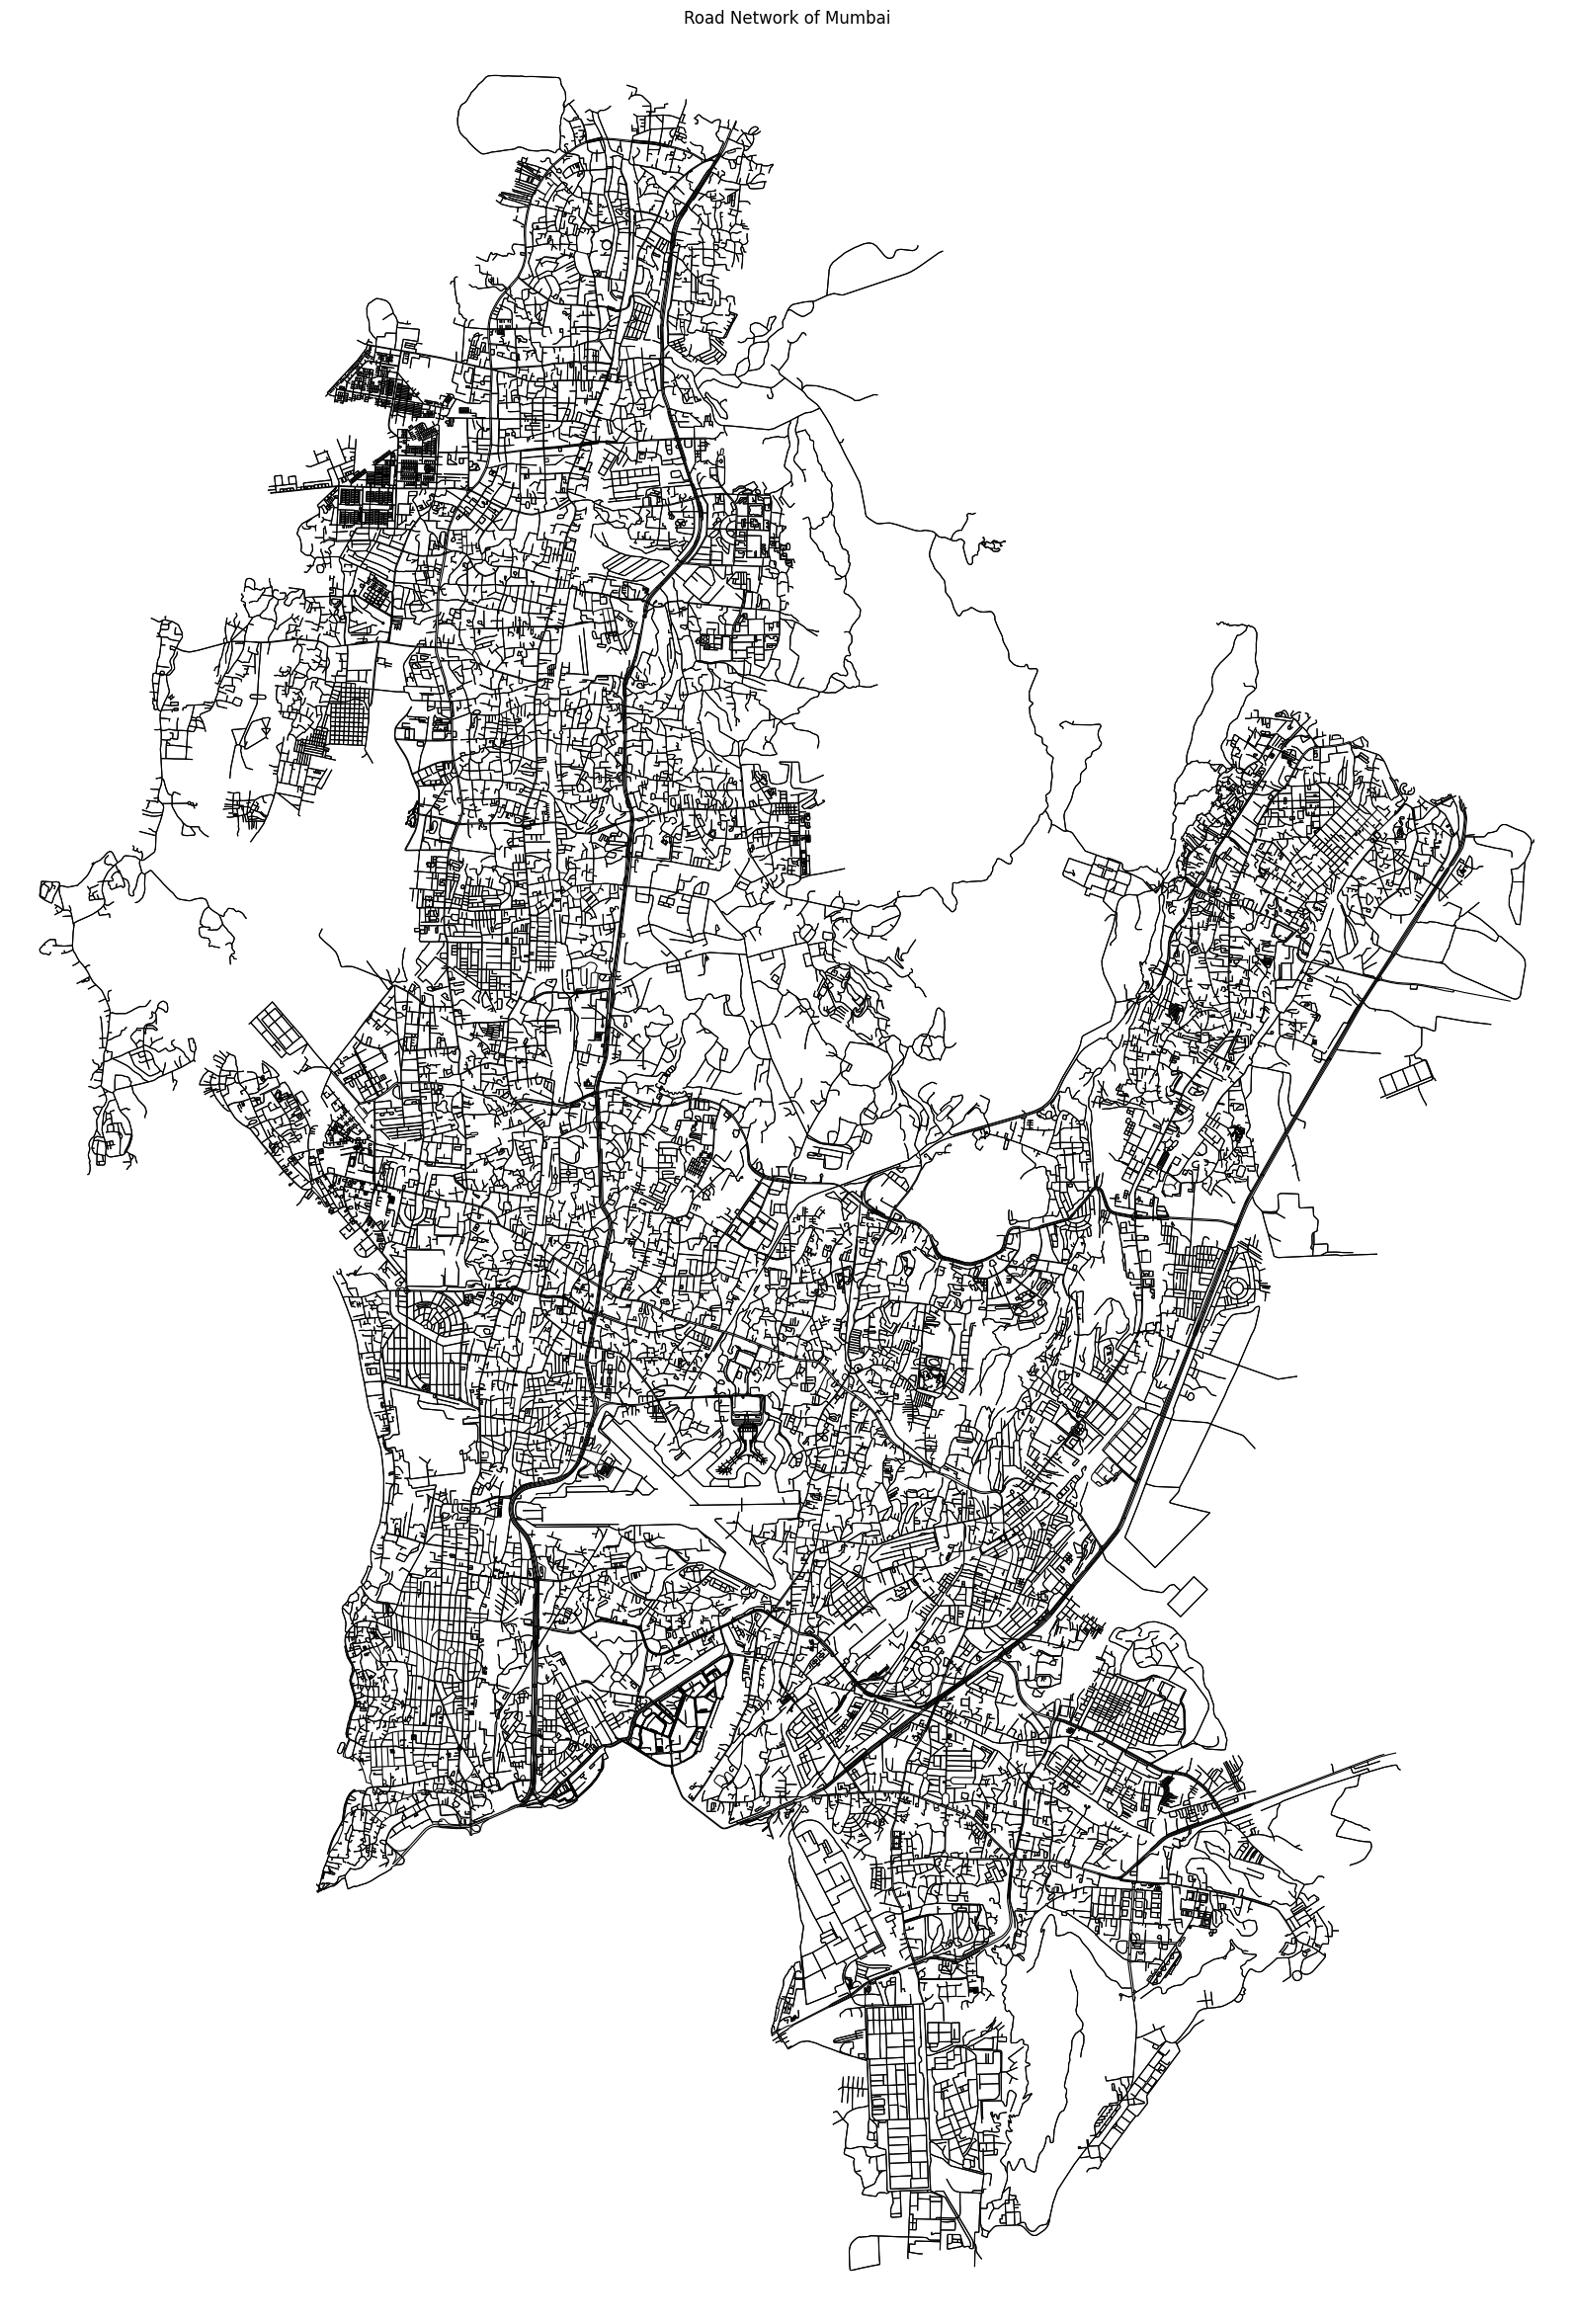

In [21]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.title("Road Network of Mumbai")
ox.plot_graph(graph, ax=ax, node_size=0, edge_color='black', edge_linewidth=0.8)
plt.show(block=False)

# Analysis

# Count Different Types Of Roads  (Highway Category)

In [22]:
road_types = edges['highway'].value_counts()
print("Road Type Counts:")
print(road_types)

Road Type Counts:
highway
residential                               38102
service                                   21385
tertiary                                  10328
secondary                                  4068
footway                                    3370
                                          ...  
[motorway_link, primary]                      1
[motorway_link, primary, primary_link]        1
[unclassified, tertiary]                      1
[motorway_link, secondary]                    1
[residential, service, unclassified]          1
Name: count, Length: 83, dtype: int64


To plot the distribution of road types based on the counts of the `highway` attribute from the `edges` DataFrame

# Plot The Road Type Counts

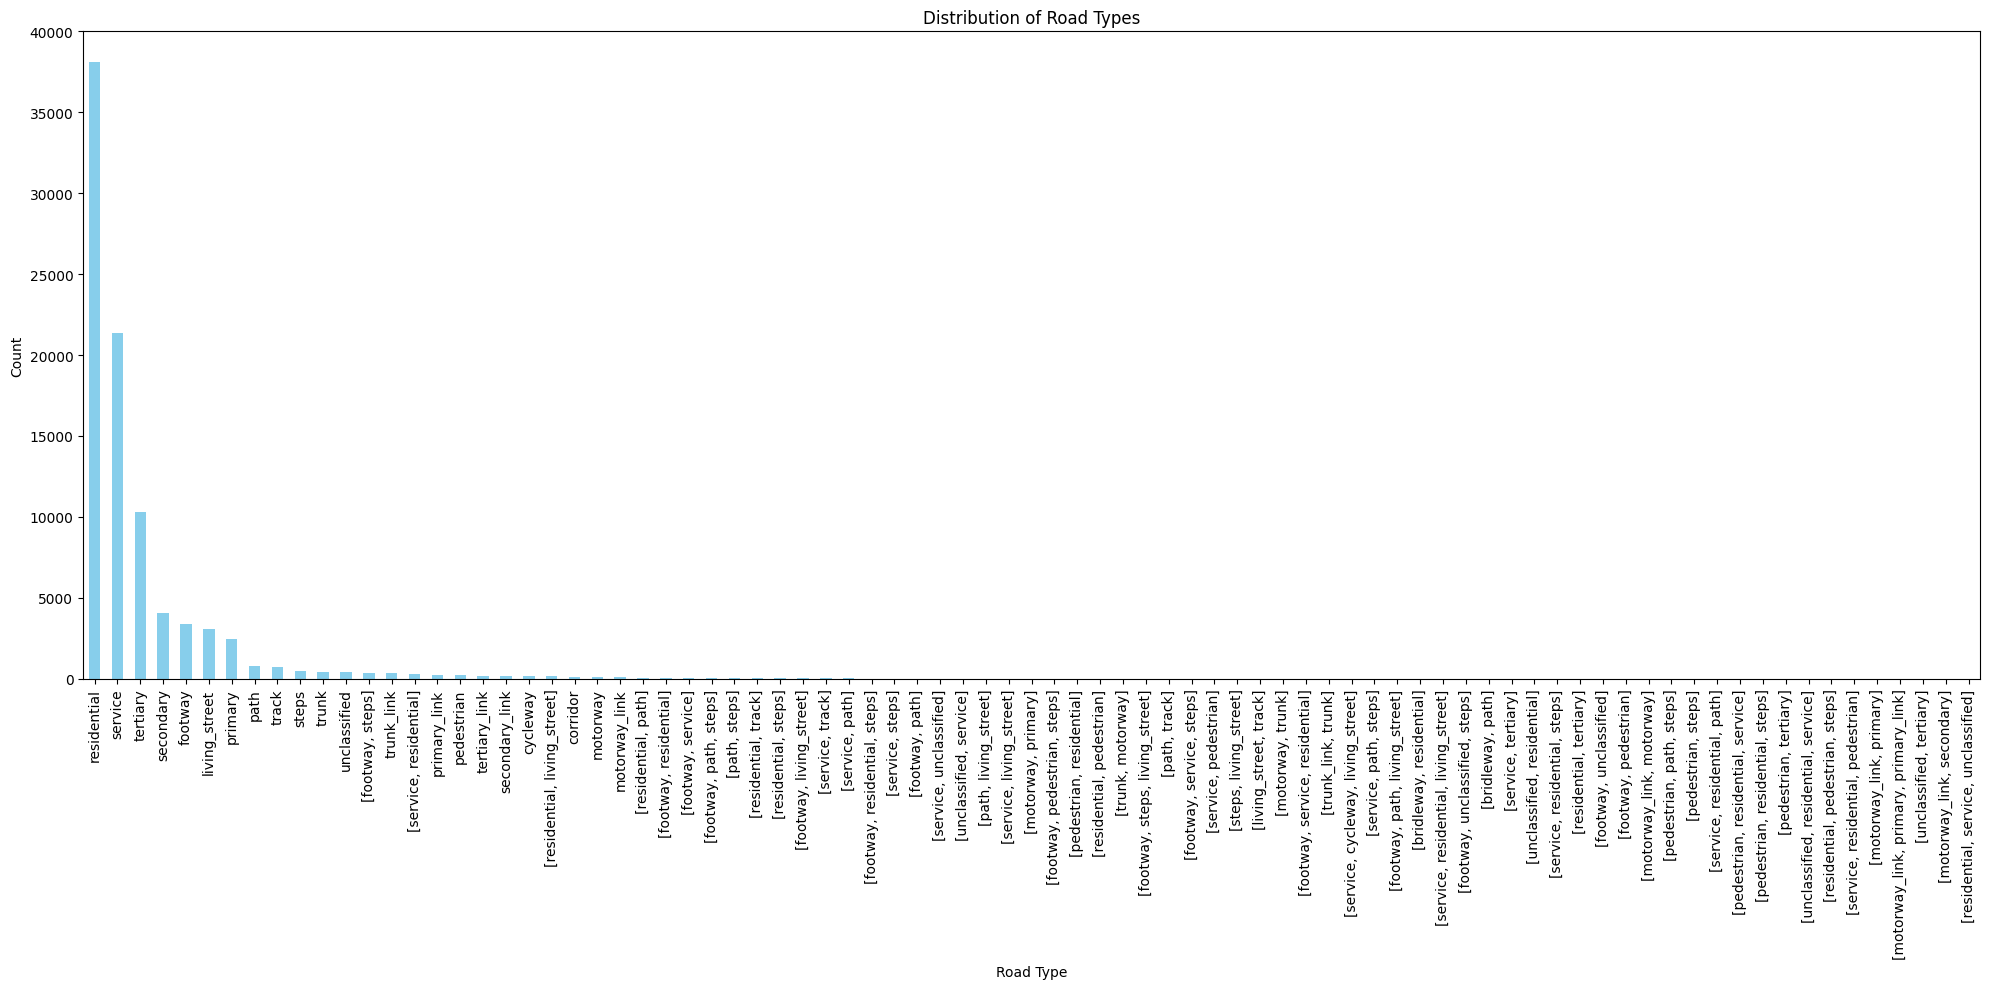

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
road_types.plot(kind='bar', ax=ax, color='skyblue')
ax.set_xlabel('Road Type')
ax.set_ylabel('Count')
ax.set_title('Distribution of Road Types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Filter And Plot Major Road Type Classification

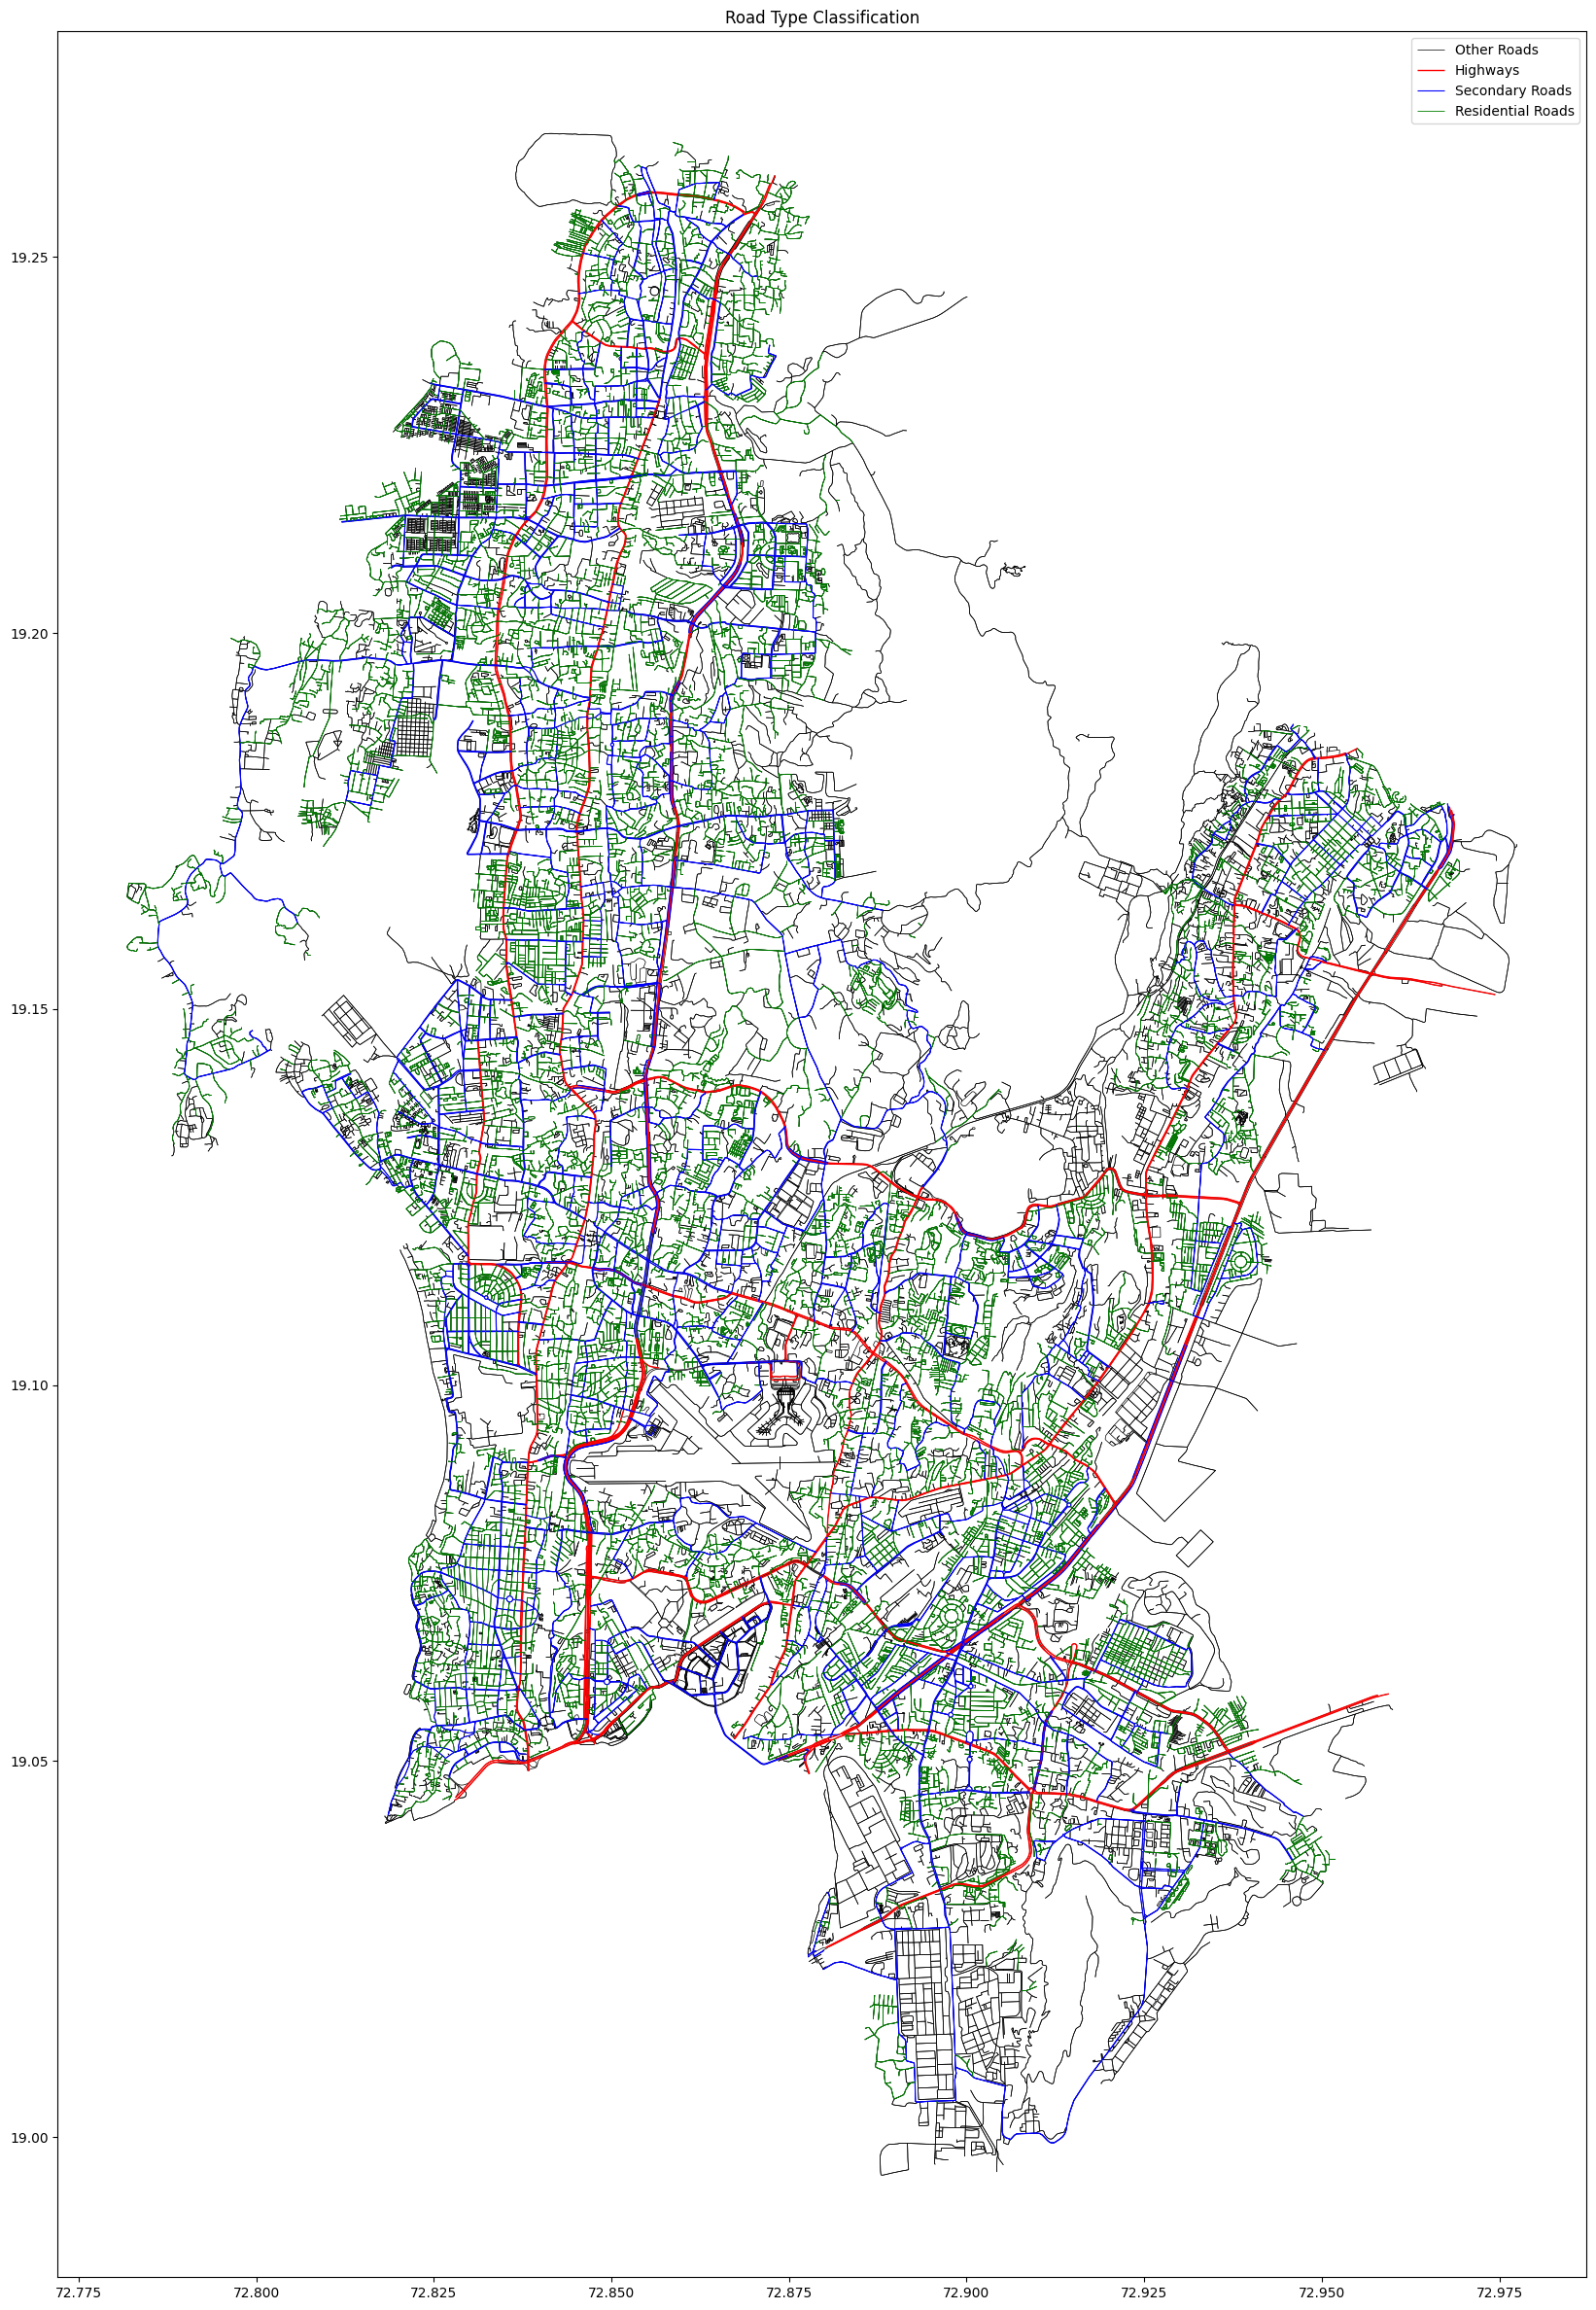

In [24]:
highways = edges[edges['highway'].isin(['motorway', 'trunk', 'primary'])]
secondary_roads = edges[edges['highway'].isin(['secondary', 'tertiary'])]
residential_roads = edges[edges['highway'].isin(['residential'])]

fig, ax = plt.subplots(figsize=(40, 30))
base = edges.plot(ax=ax, color='black', linewidth=0.5, label='Other Roads')
highways.plot(ax=base, color='red', linewidth=1, label='Highways')
secondary_roads.plot(ax=base, color='blue', linewidth=0.8, label='Secondary Roads')
residential_roads.plot(ax=base, color='green', linewidth=0.6, label='Residential Roads')
plt.legend()
plt.title("Road Type Classification")
plt.show()

# Road Length Distribution: Analyze road segment lengths to identify common patterns.
# Elevation Data: Include terrain elevation changes to assess slope and ramps.
Traffic Flow Data: Integrate traffic volume data if available.

In [65]:
edges['length_km'] = edges.length / 1000  # Convert to kilometer

C:\Users\sanjay\AppData\Local\Temp\ipykernel_7084\3325552535.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['length_km'] = edges.length / 1000  # Convert to kilometer


osmid   access       highway  \
u           v           key                                      
245659436   2216056873  0      22845139  private      tertiary   
            2216056869  0      22845139  private      tertiary   
            2216056921  0     211619420      NaN       service   
245661007   2248799196  0      22845139  private      tertiary   
            2248799258  0    1191750111  private       service   
...                                 ...      ...           ...   
12504168726 10716290058 0    1351532842      NaN       service   
            6117695042  0    1291881361      NaN  unclassified   
12506578556 10308411630 0    1116509023      NaN       primary   
            12506578576 0    1351771944  private       service   
12506578576 12506578556 0    1116509023      NaN       primary   

                                                        name  oneway reversed  \
u           v           key                                                     
245659436   2216056873  0    Central Avenue New Mandala Road   False    False   
            2216056869  0    Central Avenue New Mandala Road   False     True   
            2216056921  0                                NaN   False    False   
245661007   2248799196  0    Central Avenue New Mandala Road   False     True   
            2248799258  0    Central Avenue New Mandala Road   False    False   
...                                                      ...     ...      ...   
12504168726 10716290058 0                                NaN   False     True   
            6117695042  0                   Kanzul Iman Road    True    False   
12506578556 10308411630 0                 Goregaon Link Road    True    False   
            12506578576 0                                NaN    True    False   
12506578576 12506578556 0                 Goregaon Link Road    True    False   

                               length  \
u           v           key             
245659436   2216056873  0    0.000325   
            2216056869  0    0.001092   
            2216056921  0    0.001620   
245661007   2248799196  0    0.000776   
            2248799258  0    0.000875   
...                               ...   
12504168726 10716290058 0    0.000073   
            6117695042  0    0.001697   
12506578556 10308411630 0    0.000055   
            12506578576 0    0.001403   
12506578576 12506578556 0    0.000533   

                                                                      geometry  \
u           v           key                                                      
245659436   2216056873  0    LINESTRING (72.90949 19.00051, 72.90982 19.00052)   
            2216056869  0     LINESTRING (72.90949 19.00051, 72.9084 19.00047)   
            2216056921  0    LINESTRING (72.90949 19.00051, 72.90944 19.00213)   
245661007   2248799196  0     LINESTRING (72.92463 19.01741, 72.9242 19.01677)   
            2248799258  0    LINESTRING (72.92463 19.01741, 72.92515 19.01812)   
...                                                                        ...   
12504168726 10716290058 0      LINESTRING (72.86379 19.068, 72.86375 19.06806)   
            6117695042  0    LINESTRING (72.86379 19.068, 72.86281 19.06738...   
12506578556 10308411630 0    LINESTRING (72.83693 19.17701, 72.83692 19.17707)   
            12506578576 0    LINESTRING (72.83693 19.17701, 72.83685 19.177...   
12506578576 12506578556 0    LINESTRING (72.83702 19.17649, 72.83693 19.17701)   

                            lanes junction  ... maxspeed tunnel service width  \
u           v           key                 ...                                 
245659436   2216056873  0     NaN      NaN  ...      NaN    NaN     NaN   NaN   
            2216056869  0     NaN      NaN  ...      NaN    NaN     NaN   NaN   
            2216056921  0     NaN      NaN  ...      NaN    NaN     NaN   NaN   
245661007   2248799196  0     NaN      NaN  ...      NaN    NaN     NaN   NaN   
            2248799258  0     NaN 

# Summary For Foad Lengths

In [66]:
edges['length_km']

u            v            key
245659436    2216056873   0      3.249193e-07
             2216056869   0      1.092127e-06
             2216056921   0      1.619600e-06
245661007    2248799196   0      7.761928e-07
             2248799258   0      8.745678e-07
                                     ...     
12504168726  10716290058  0      7.323749e-08
             6117695042   0      1.696680e-06
12506578556  10308411630  0      5.517246e-08
             12506578576  0      1.403058e-06
12506578576  12506578556  0      5.334279e-07
Name: length_km, Length: 88419, dtype: float64

In [67]:
edges[['length_km', 'road_type']]

length_km road_type
u           v           key                        
245659436   2216056873  0    3.249193e-07  Straight
            2216056869  0    1.092127e-06  Straight
            2216056921  0    1.619600e-06  Straight
245661007   2248799196  0    7.761928e-07  Straight
            2248799258  0    8.745678e-07  Straight
...                                   ...       ...
12504168726 10716290058 0    7.323749e-08  Straight
            6117695042  0    1.696680e-06  Straight
12506578556 10308411630 0    5.517246e-08  Straight
            12506578576 0    1.403058e-06    Zigzag
12506578576 12506578556 0    5.334279e-07  Straight

[88419 rows x 2 columns]

In [68]:
edges['length_km'].sum()

0.07205392924186182

In [72]:
edges['length_km'].value_counts()

length_km
5.620648e-07    20
5.620648e-07     8
4.913154e-07     8
4.781397e-07     6
2.135485e-07     6
                ..
6.544849e-07     1
7.761495e-08     1
5.109991e-07     1
2.086825e-06     1
5.334279e-07     1
Name: count, Length: 54549, dtype: int64

In [73]:
grouped_counts = edges.groupby('road_type')['length_km'].value_counts()
print(grouped_counts)


road_type  length_km   
Circular   6.898230e-07    2
           6.904821e-07    2
           6.874429e-07    2
           6.875609e-07    2
           6.875805e-07    2
                          ..
Zigzag     1.489652e-06    1
           1.489759e-06    1
           1.489759e-06    1
           1.491144e-06    1
           4.705784e-05    1
Name: count, Length: 54549, dtype: int64


In [74]:
grouped_percentage = edges.groupby('road_type')['length_km'].value_counts(normalize=True)
print(grouped_percentage)


road_type  length_km   
Circular   1.875539e-06    0.000288
           6.976234e-07    0.000288
           6.942035e-07    0.000288
           6.947377e-07    0.000288
           6.951184e-07    0.000288
                             ...   
Zigzag     1.057574e-06    0.000075
           3.710442e-06    0.000075
           1.058153e-06    0.000075
           6.342700e-06    0.000075
           4.705784e-05    0.000075
Name: proportion, Length: 54549, dtype: float64


In [75]:
total_length_per_type = edges.groupby('road_type')['length_km'].sum()
print(total_length_per_type)


road_type
Circular    0.004807
Curved      0.014782
Straight    0.031150
Zigzag      0.021314
Name: length_km, dtype: float64


In [76]:
crosstab_result = pd.crosstab(edges['length_km'], edges['road_type'])
print(crosstab_result)


road_type     Circular  Curved  Straight  Zigzag
length_km                                       
1.503330e-09         0       0         2       0
2.416609e-09         0       0         2       0
2.692582e-09         0       0         2       0
4.254409e-09         0       0         2       0
4.332436e-09         0       0         1       0
...                ...     ...       ...     ...
3.610916e-05         0       0         0       1
3.803578e-05         0       0         0       1
3.803578e-05         0       0         0       1
4.705784e-05         0       0         0       1
4.705784e-05         0       0         0       1

[54549 rows x 4 columns]


In [77]:
print(edges['length_km'].describe())  # Summary statistics for road lengths

count    8.841900e+04
mean     8.149145e-07
std      1.092812e-06
min      1.503330e-09
25%      2.626077e-07
50%      5.545503e-07
75%      1.012781e-06
max      4.705784e-05
Name: length_km, dtype: float64


# Plot Road Length Distribution

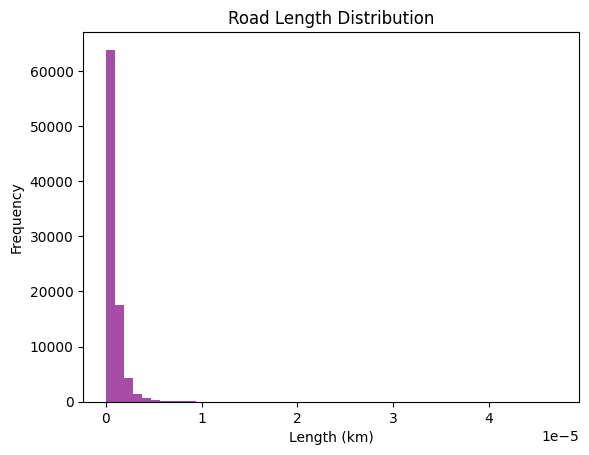

In [78]:
plt.hist(edges['length_km'], bins=50, color='purple', alpha=0.7)
plt.title("Road Length Distribution")
plt.xlabel("Length (km)")
plt.ylabel("Frequency")
plt.show()

# Network Connectivity Analysis
Analyze connectivity of the road network to identify:

Dead-end roads (cul-de-sacs).
Highly connected intersections.
Shortest path calculations using Dijkstra’s algorithm

# Identify Dead-End Roads

In [28]:
dead_ends = [node for node, degree in dict(graph.degree()).items() if degree == 1]
print("Dead-End Roads (Cul-de-Sacs):", dead_ends)

Dead-End Roads (Cul-de-Sacs): [245665780, 297129851, 1728805936, 2125201337, 4625570743, 7279745893, 9582224064, 9584654510, 9584654511, 11064635094, 12311629162]


# Define A Threshold For Highly Connected Intersections

In [29]:
threshold = 4

# Identify highly connected intersections
highly_connected = [node for node, degree in dict(graph.degree()).items() if degree >= threshold]
print("Highly Connected Intersections:", highly_connected)


Highly Connected Intersections: [245659436, 245661007, 245662490, 245663220, 245663253, 245663476, 245663765, 245663817, 245663961, 245664055, 245664114, 245664549, 245664662, 245664742, 245664764, 245664830, 245664842, 245664865, 245664869, 245664905, 245665035, 245665060, 245665075, 245665113, 245665146, 245665177, 245665186, 245665197, 245665218, 245665268, 245665270, 245665275, 245665303, 245665304, 245665307, 245665344, 245665351, 245665354, 245665375, 245665402, 245665419, 245665466, 245665475, 245665491, 245665495, 245665507, 245665516, 245665566, 245665583, 245665597, 245665613, 245665614, 245665628, 245665629, 245665630, 245665633, 245665637, 245665648, 245665650, 245665666, 245665667, 245665679, 245665680, 245665702, 245665715, 245665716, 245665717, 245665723, 245665733, 245665748, 245665767, 245665768, 245665776, 245665786, 245665788, 245665823, 245665837, 245665874, 245665907, 245665910, 245665925, 245665938, 245665949, 245665975, 245665976, 245665982, 245666000, 245666002,

# Define Origin And Destination Points (latitude, longitude)

In [30]:
orig = ox.distance.nearest_nodes(graph, 72.8777, 19.0760)  # Mumbai coordinates
dest = ox.distance.nearest_nodes(graph, 72.8352, 19.0180)  # another point in Mumbai

# Calculate The Shortest Path

In [31]:
shortest_path = nx.shortest_path(graph, orig, dest, weight='length', method='dijkstra')
print("Shortest Path:", shortest_path)

Shortest Path: [1366009125, 245668003, 6497126509, 2246472366, 6575923290, 619309810, 2622177275, 10877916790, 10877916800, 6552758940, 296857791, 2897024818, 2897024816, 10279771623, 631507992, 2897024795, 10279771627, 245666966, 2897024737, 10921476127, 11182854437, 2897024659, 2897024651, 296853816, 2897024648, 9816803830, 2897024628, 2897024615, 296857806, 2897024601, 2897024540, 2897024523, 296857831, 2897024519, 11271653051, 12011636640, 1398117085, 8928692503, 8443491302, 8882200680, 245664576, 245664463, 245664445, 2250795688, 346604059, 472814070, 11954345392, 4801979438]


# Highlight Shortest Path On The Map

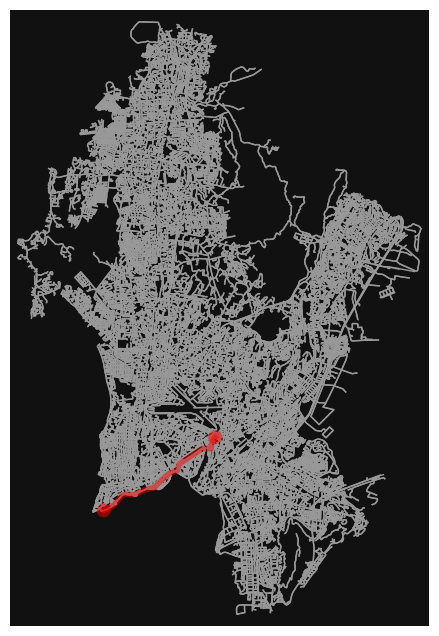

In [32]:
fig, ax = ox.plot_graph_route(graph, shortest_path, route_linewidth=4, node_size=0)

## Clustering Roads for Pattern Detection
Use clustering algorithms (K-Means) to detect clusters of similar road types based on length, curvature, and connectivity.

In [33]:
X = edges[['length_km']].values  # Example: clustering by length
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
edges['cluster'] = kmeans.labels_

# Plot Road Clusters With Basemap

Text(0.5, 1.0, 'Road Clusters with Basemap')

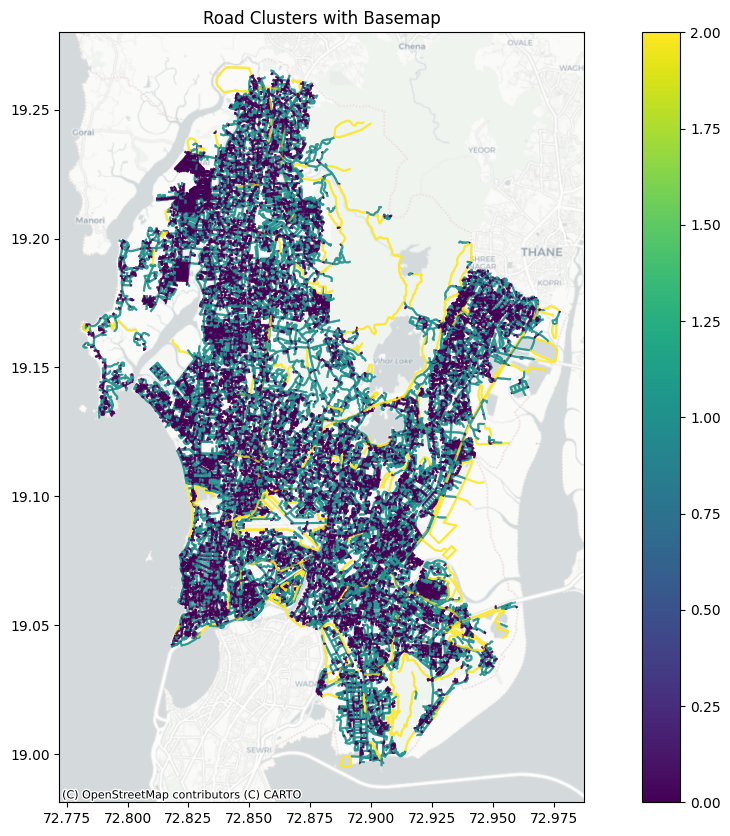

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
edges.plot(column='cluster', cmap='viridis', legend=True, alpha=0.7, ax=ax)
ctx.add_basemap(ax, crs=edges.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.title("Road Clusters with Basemap")

# Save Processed Data For Further Analysis

In [ ]:
edges.to_file("road_network_analysis.geojson", driver='GeoJSON')

## Conclusion and Benefits of the Road Network Analysis and Classification

### 1. Road Classification and Analysis

- **Curvature-Based Classification:**\
  Classifying roads into categories such as *Straight*, *Curved*, *Zigzag*, and *Circular* provides insights into road design, which is useful in transportation planning and infrastructure development.
- **Feature Enrichment:**\
  Attributes like *road length*, *highway type*, and *residential classification* provide additional context for urban planning, road maintenance, and traffic management.

### 2. Road Network Visualization

- **Spatial Distribution:**\
  Visualizing road networks and their classifications helps in urban planning and identifying areas for improvement.
- **Cluster Visualization:**\
  Clustering roads based on features like length reveals patterns, aiding in traffic and infrastructure planning.

### 3. Machine Learning Application

- **Predictive Modeling:**\
  Machine learning algorithms like Random Forests allow automated classification of road types, enabling real-time updates to road networks.
- **Model Performance:**\
  Cross-validation ensures model accuracy and reliability for classification.

### 4. Road Length Distribution and Clustering

- **Understanding Road Length Variations:**\
  Analyzing the distribution of road lengths helps identify trends such as the predominance of short or long roads.
- **Cluster Analysis:**\
  KMeans clustering groups roads based on similar features, aiding in prioritization for maintenance and development.

### 5. Data-Driven Urban Planning

- **Improved Decision Making:**\
  Insights from road network analysis help urban planners and government agencies make informed decisions about infrastructure investments.
- **Targeted Infrastructure Improvements:**\
  The classification of roads based on curvature and other features enables targeted improvements, such as reducing congestion or enhancing safety.

## Benefits

- **Improved Transportation Efficiency:**\
  Optimizing traffic flow and making infrastructure adjustments to reduce congestion and enhance road safety.
- **Enhanced Urban Planning:**\
  Ensuring that the right types of roads are placed in appropriate areas to improve city functionality.
- **Cost Savings:**\
  Efficient resource allocation for road maintenance and construction.
- **Data-Driven Decision Making:**\
  Actionable insights for urban development strategies and road safety im  provements.

## Final Thoughts

The integration of machine learning, spatial analysis, and network modeling leads to better-informed decisions and improved urban mobility, benefiting both residents and city planners.



# 👨‍💻 Developer

This Project Was Developed And Built By Punjaji Karhale🚀